# CAB420 Assignment 1A
- First Name: Aidan
- Last Name: Lockwood
- Student Number: n10515402

In [123]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.io import loadmat 
import h5py
import seaborn as sns
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import distance_metrics

In [67]:
# importing all relevant data
q1_train = pd.read_csv('data/Q1/communities_train.csv')
q1_test = pd.read_csv('data/Q1/communities_test.csv')
q1_val = pd.read_csv('data/Q1/communities_val.csv')

q2_train = pd.read_csv('data/Q2/training.csv')
q2_test = pd.read_csv('data/Q2/testing.csv')
q2_val = pd.read_csv('data/Q2/validation.csv')

q3_train_path = 'data/Q3/q3_train.mat'
q3_test_path = 'data/Q3/q3_test.mat'
q3_val_path = 'data/Q3/q3_validation.mat'

q3_train = loadmat('data/Q3/q3_train.mat')['train_X']
q3_test = loadmat('data/Q3/q3_test.mat')['test_X']
q3_val = loadmat('data/Q3/q3_validation.mat')['val_X']

Some functions used throughout this file to calculate evaluation metrics

In [68]:
# Function used to evaluate the model metrics
def eval_model_metrics(model, X_train, Y_train):
    # Run the predictions off the model
    y_pred = model.predict(X_train)

    # Calculate R^2 and adjusted R^2, sum of residual squares and sum of total squares
    ss_res = np.sum((Y_train - y_pred)**2)
    ss_tot = np.sum((Y_train - np.mean(Y_train))**2)
    r2 = 1 - (ss_res / ss_tot)

    adjusted_r2 = 1 - (1 - r2) * (len(Y_train) - 1) / (len(Y_train) - X_train.shape[1] - 1)


    return (y_pred, ss_res, ss_tot, r2, adjusted_r2)

A function taken from tutorial week 3 content to evaluate the models

In [111]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

## Question 1 - Regression
The data in the Q1 directory in CAB420 Assessment 1A Data.zip contains socio-economic data from the 1990 US census for various US communities, and the number of violent crimes per capita (in the column ViolentCrimesPerPop). The purpose of the data is to explore the link between the various socio-economic factors and crime. The provided data has been split into training (communities train), validation (communities val), and testing (communities test) sets.

### Using this data
You are to:

- Train a linear regression model to predict the number of violent crimes per captia from the socio-economic data.
- Train a Ridge regression model to predict the number of violent crimes per captia from the socio-economic data.
- Train a LASSO regression model to predict the number of violent crimes per captia from the socio-economic data.

For your analysis, you are to use all provided data (i.e. DO NOT perform any filtering or selection to remove columns and/or rows). For LASSO and Ridge models, the validation dataset should be used to select the optimal value of λ. All models should be evaluated on the test set. Evaluations should consider the predictive power of the model, the model complexity, and the model validity.

### Preprocessing the Data

In [69]:
q1_val.columns.to_list()

[' population ',
 ' householdsize ',
 ' racepctblack ',
 ' racePctWhite ',
 ' racePctAsian ',
 ' racePctHisp ',
 ' agePct12t21 ',
 ' agePct12t29 ',
 ' agePct16t24 ',
 ' agePct65up ',
 ' numbUrban ',
 ' pctUrban ',
 ' medIncome ',
 ' pctWWage ',
 ' pctWFarmSelf ',
 ' pctWInvInc ',
 ' pctWSocSec ',
 ' pctWPubAsst ',
 ' pctWRetire ',
 ' medFamInc ',
 ' perCapInc ',
 ' whitePerCap ',
 ' blackPerCap ',
 ' indianPerCap ',
 ' AsianPerCap ',
 ' OtherPerCap ',
 ' HispPerCap ',
 ' NumUnderPov ',
 ' PctPopUnderPov ',
 ' PctLess9thGrade ',
 ' PctNotHSGrad ',
 ' PctBSorMore ',
 ' PctUnemployed ',
 ' PctEmploy ',
 ' PctEmplManu ',
 ' PctEmplProfServ ',
 ' PctOccupManu ',
 ' PctOccupMgmtProf ',
 ' MalePctDivorce ',
 ' MalePctNevMarr ',
 ' FemalePctDiv ',
 ' TotalPctDiv ',
 ' PersPerFam ',
 ' PctFam2Par ',
 ' PctKids2Par ',
 ' PctYoungKids2Par ',
 ' PctTeen2Par ',
 ' PctWorkMomYoungKids ',
 ' PctWorkMom ',
 ' NumIlleg ',
 ' PctIlleg ',
 ' NumImmig ',
 ' PctImmigRecent ',
 ' PctImmigRec5 ',
 ' PctImmig

In [70]:
# Removing the whitespace from the column names
q1_train.columns = q1_train.columns.str.strip()
q1_test.columns = q1_test.columns.str.strip()
q1_val.columns = q1_val.columns.str.strip()

In [71]:
# Selecting X and Y for each of the Q1 datasets
y_q1_train = q1_train['ViolentCrimesPerPop']
y_q1_train = y_q1_train.to_numpy()
X_q1_train = q1_train.drop(columns=['ViolentCrimesPerPop'])
X_q1_train = X_q1_train.to_numpy()

y_q1_test = q1_test['ViolentCrimesPerPop']
y_q1_test = y_q1_test.to_numpy()
X_q1_test = q1_test.drop(columns=['ViolentCrimesPerPop'])
X_q1_test = X_q1_test.to_numpy()

y_q1_val = q1_val['ViolentCrimesPerPop']
y_q1_val = y_q1_val.to_numpy()
X_q1_val = q1_val.drop(columns=['ViolentCrimesPerPop'])
X_q1_val = X_q1_val.to_numpy()


### Training the Linear Regression Model

In [72]:
linear_regression_model = sm.OLS(y_q1_train, X_q1_train).fit()
linear_regression_training_metrics = eval_model_metrics(linear_regression_model, X_q1_train, y_q1_train)
linear_regression_testing_metrics = eval_model_metrics(linear_regression_model, X_q1_test, y_q1_test)

linear_regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              15.99
Date:                Tue, 25 Mar 2025   Prob (F-statistic):                    2.30e-58
Time:                        10:28:20   Log-Likelihood:                          250.64
No. Observations:                 298   AIC:                                     -301.3
Df Residuals:                     198   BIC:                                      68.43
Df Model:                         100                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8957      1.222      0.733      0.464      -1.514       3.305
x2            -0.4417      0.280     -1.578      0.116      -0.994       0.110
x3             0.0842      0.146      0.579      0.563      -0.203       0.371
x4            -0.0620      0.147     -0.421      0.674      -0.352       0.228
x5            -0.0631      0.089     -0.709      0.479      -0.239       0.113
x6            -0.3438      0.146     -2.348      0.020      -0.632      -0.055
x7            -0.1910      0.309     -0.619      0.537      -0.800       0.418
x8             0.8179      0.470      1.740      0.083      -0.109       1.745
x9            -0.2193      0.501     -0.438      0.662      -1.207       0.768
x10            0.1635      0.263      0.621      0.535      -0.355       0.682
x11           -0.8869      1.166     -0.761      0.448      -3.186       1.412
x12            0.0784      0.047      1.680      0.095      -0.014       0.170
x13           -0.3741      0.606     -0.618      0.538      -1.569       0.820
x14           -0.2158      0.257     -0.841      0.402      -0.722       0.291
x15            0.0599      0.062      0.968      0.334      -0.062       0.182
x16           -0.1904      0.193     -0.987      0.325      -0.571       0.190
x17            0.2720      0.298      0.914      0.362      -0.315       0.859
x18            0.1232      0.148      0.834      0.405      -0.168       0.415
x19           -0.0949      0.100     -0.946      0.346      -0.293       0.103
x20            0.5281      0.552      0.956      0.340      -0.561       1.617
x21            0.6679      0.600      1.113      0.267      -0.515       1.851
x22           -0.6073      0.490     -1.240      0.216      -1.573       0.358
x23            0.0167      0.071      0.235      0.815      -0.123       0.157
x24           -0.0784      0.057     -1.377      0.170      -0.191       0.034
x25            0.1025      0.061      1.687      0.093      -0.017       0.222
x26           -0.0330      0.052     -0.640      0.523      -0.135       0.069
x27            0.0458      0.068      0.671      0.503      -0.089       0.180
x28           -0.3309      0.397     -0.833      0.406      -1.114       0.452
x29           -0.2593      0.196     -1.321      0.188      -0.646       0.128
x30           -0.1923      0.209     -0.919      0.359      -0.605       0.220
x31            0.2821      0.291      0.971      0.333      -0.291       0.855
x32            0.3083      0.238      1.293      0.197      -0.162       0.778
x33           -0.1812      0.125     -1.446      0.150      -0.428       0.066
x34            0.2572      0.247      1.042      0.299      -0.230       0.744
x35           -0.0968      0.090     -1.075      0.284      -

In [73]:
linear_regression_training_metrics

(array([ 0.0107386 ,  0.19808042,  0.07437772,  0.05133491,  0.04669757,
        -0.02515139,  0.24961791,  0.07518594,  0.32138691,  0.40525404,
         0.08482055,  0.39823629,  0.12059115, -0.02054362,  0.18489558,
         0.25596883,  0.10715743,  0.1881982 ,  0.30696176,  0.45711632,
         0.19479324,  0.29954443,  0.13473247,  0.09289197,  0.48974857,
         0.08744686,  0.43194642,  0.10116046,  0.39520868,  0.29535767,
         0.57300783,  0.12526149,  0.07043595,  0.66518089,  0.19362087,
         0.07122568,  0.13991686,  0.47410727,  0.15771043,  0.38613693,
         0.24901892,  0.18275349,  0.50782536,  0.22869548,  0.01613139,
         0.42973083,  0.09897224, -0.01481993,  0.33822509,  0.0030577 ,
         0.24870393,  0.14833666,  0.10307561,  0.47311255,  0.54334599,
         0.21078918,  0.12553536,  0.03030199,  0.18696913,  0.47612069,
         0.14935461,  0.10093713,  0.37124501,  0.43978782, -0.00451524,
         0.28228399,  0.09228246,  0.416689  ,  0.1

Generating the Q-Q Plot and the plot of residuals to check the assumption of normality

RMSE Train of Linear Model: 0.10434982356247434
RMSE Test of Linear Model: 0.15423502604443437


Text(0.5, 1.0, 'Predicted Values vs Residuals')

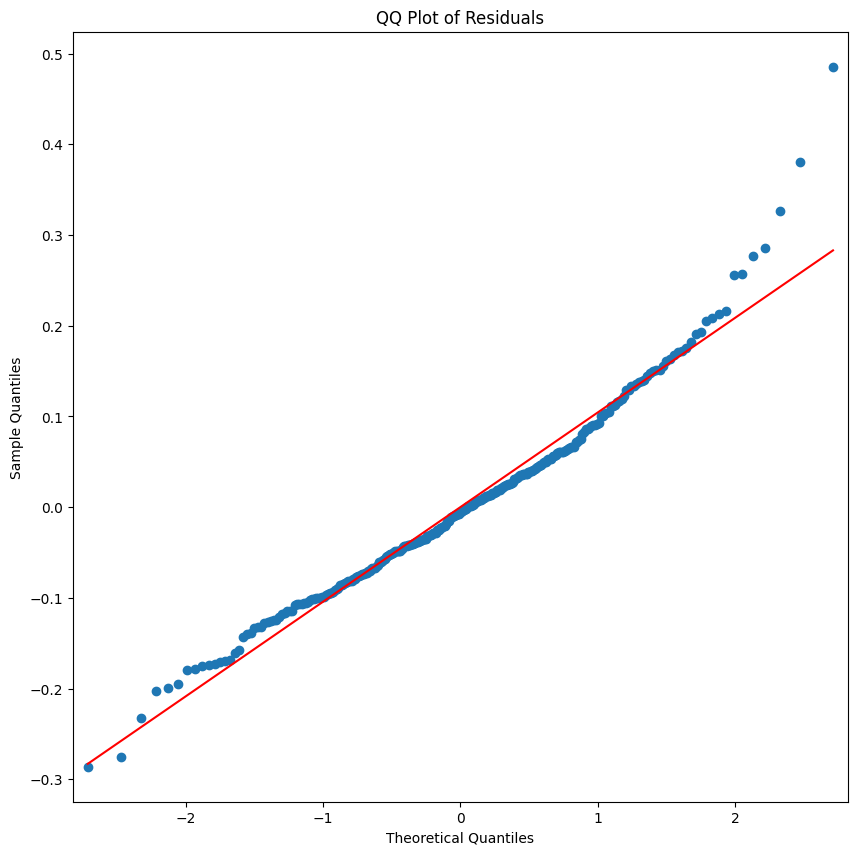

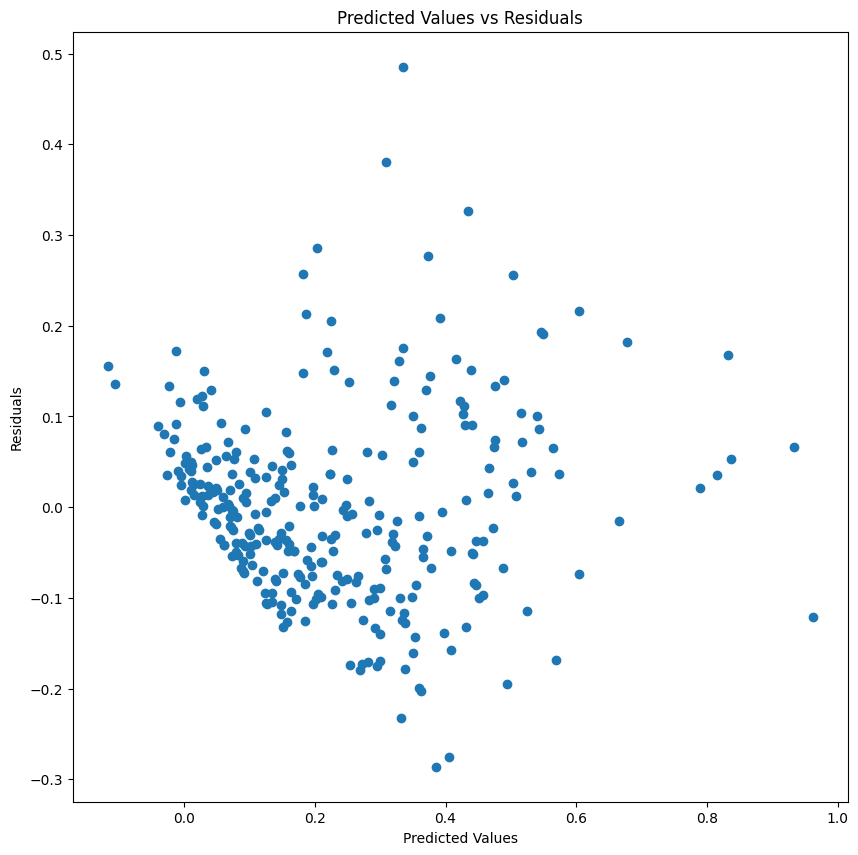

In [74]:
# QQ Plot
rmse_train = np.sqrt(mean_squared_error(y_q1_train, linear_regression_training_metrics[0]))
rmse_test = np.sqrt(mean_squared_error(y_q1_test, linear_regression_testing_metrics[0]))

print(f'RMSE Train of Linear Model: {rmse_train}')
print(f'RMSE Test of Linear Model: {rmse_test}')


fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(linear_regression_model.resid, line='s', ax=ax)
plt.title('QQ Plot of Residuals')

# Plot of residuals
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(linear_regression_training_metrics[0], linear_regression_model.resid)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted Values vs Residuals')

### Training the Ridge Model

In [75]:
ridge_regression_model = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = 1, L1_wt = 0)
y_q1_train_pred_ridge = ridge_regression_model.predict(X_q1_train)

ridge_regression_training_metrics = eval_model_metrics(ridge_regression_model,X_q1_train, y_q1_train)
ridge_regression_testing_metrics = eval_model_metrics(ridge_regression_model,X_q1_test, y_q1_test)


### Finding the Optimal Value for Lambda, then Retraining

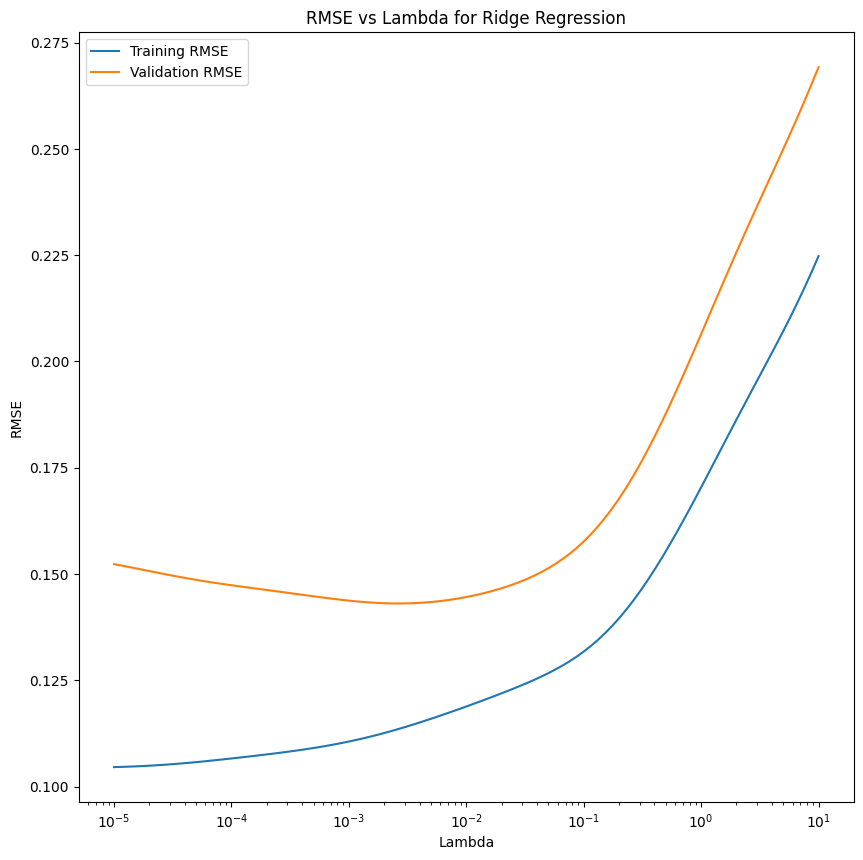

In [76]:
lambda_values = np.logspace(-5, 1, 100)

ridge_rmse_train_values = []
ridge_rmse_validation_values = []

for l in lambda_values: 
    model = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = l, L1_wt = 0)
    y_q1_train_pred = model.predict(X_q1_train)
    y_q1_val_pred = model.predict(X_q1_val)
    ridge_rmse_train = np.sqrt(mean_squared_error(y_q1_train, y_q1_train_pred))
    ridge_rmse_val = np.sqrt(mean_squared_error(y_q1_val, y_q1_val_pred))
    ridge_rmse_train_values.append(ridge_rmse_train)
    ridge_rmse_validation_values.append(ridge_rmse_val)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lambda_values, ridge_rmse_train_values, label='Training RMSE')
ax.plot(lambda_values, ridge_rmse_validation_values, label='Validation RMSE')
ax.set_xscale('log')
ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Lambda for Ridge Regression')
ax.legend()

In [77]:
min_ridge_lambda = min(ridge_rmse_validation_values)

position_optimal_ridge_lambda = ridge_rmse_validation_values.index(min_ridge_lambda)
optimal_ridge_lambda = lambda_values[position_optimal_ridge_lambda]

ridge_regression_model_optimised = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = optimal_ridge_lambda, L1_wt = 1)
y_q1_train_pred_ridge_optimised = ridge_regression_model_optimised.predict(X_q1_train)

ridge_regression_training_metrics_optimised = eval_model_metrics(ridge_regression_model_optimised, X_q1_train, y_q1_train)
ridge_regression_testing_metrics_optimised = eval_model_metrics(ridge_regression_model_optimised, X_q1_test, y_q1_test)

print(f'Optimal Lambda for Ridge Regression: {optimal_ridge_lambda}')
rmse_train = np.sqrt(mean_squared_error(y_q1_train, ridge_regression_training_metrics_optimised[0]))
print(f'RMSE Train of Ridge Model: {rmse_train}')
rmse_test = np.sqrt(mean_squared_error(y_q1_test, ridge_regression_testing_metrics_optimised[0]))
print(f'RMSE Test of Ridge Model: {rmse_test}')

Optimal Lambda for Ridge Regression: 0.0026560877829466868
RMSE Train of Ridge Model: 0.13192154311263088
RMSE Test of Ridge Model: 0.13300568709905417


### Training the Lasso Model

In [78]:
lasso_regression_model = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = 1, L1_wt = 1)
y_q1_train_pred_lasso = lasso_regression_model.predict(X_q1_train)

lasso_regression_training_metrics = eval_model_metrics(lasso_regression_model, X_q1_train, y_q1_train)
lasso_regression_testing_metrics = eval_model_metrics(lasso_regression_model, X_q1_test, y_q1_test)

### Finding the Optimal Value of Lambda and Retraining

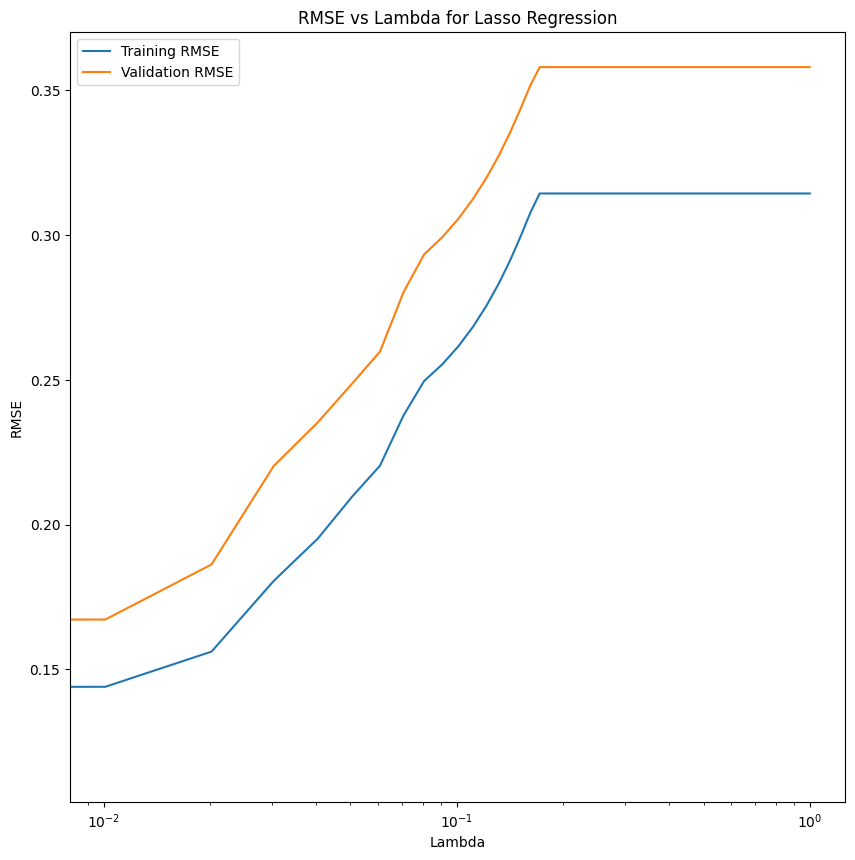

In [79]:
lambda_values = np.linspace(0, 1, 100)

lasso_rmse_train_values = []
lasso_rmse_validation_values = []

for l in lambda_values:
    model = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = l, L1_wt = 1)
    y_q1_train_pred = model.predict(X_q1_train)
    y_q1_val_pred = model.predict(X_q1_val)
    rmse_train = np.sqrt(mean_squared_error(y_q1_train, y_q1_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_q1_val, y_q1_val_pred))
    lasso_rmse_train_values.append(rmse_train)
    lasso_rmse_validation_values.append(rmse_val)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lambda_values, lasso_rmse_train_values, label='Training RMSE')
ax.plot(lambda_values, lasso_rmse_validation_values, label='Validation RMSE')

ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.set_xscale('log')
ax.set_title('RMSE vs Lambda for Lasso Regression')
ax.legend()

In [80]:
min_lasso_lambda = min(lasso_rmse_validation_values)

position_optimal_lasso_lambda = lasso_rmse_validation_values.index(min_lasso_lambda)
optimal_lasso_lambda = lambda_values[position_optimal_lasso_lambda]

lasso_regression_model_optimised = sm.OLS(y_q1_train, X_q1_train).fit_regularized(alpha = optimal_lasso_lambda, L1_wt = 1)
y_q1_train_pred_lasso_optimised = lasso_regression_model_optimised.predict(X_q1_train)

lasso_regression_training_metrics_optimised = eval_model_metrics(lasso_regression_model_optimised, X_q1_train, y_q1_train)
lasso_regression_testing_metrics_optimised = eval_model_metrics(lasso_regression_model_optimised, X_q1_test, y_q1_test)

print(f'The selected value of lambda for Lasso Regression is: {optimal_lasso_lambda}')
rmse_train = np.sqrt(mean_squared_error(y_q1_train, lasso_regression_training_metrics_optimised[0]))
print(f'RMSE Train of Lasso Model: {rmse_train}')
rmse_test = np.sqrt(mean_squared_error(y_q1_test, lasso_regression_testing_metrics_optimised[0]))
print(f'RMSE Test of Lasso Model: {rmse_test}')

The selected value of lambda for Lasso Regression is: 0.0
RMSE Train of Lasso Model: 0.1161747881295415
RMSE Test of Lasso Model: 0.1341821511477213


## Discussion of Findings

Discussion Checklist:
- a discussion of any pre-processing you did and why; or why you left the data as-is
- a discussion of how you selected the values of lambda used in your regularised models, and what those values are
- a comparison of three models, considering both the accuracy and validity of the models, as outlined above, this means:
> accuracy of the model
> measures of fit, such as R^2
> testing assumptions about the independence of predictors, and the distribution of the residuals
- A discussion of the ethical concerns that need to be considered when evaluating the models developed for this problem

Only one step of pre-processing was completed when preparing the data. While attempting to select the response variable for the model, it appeared that whitespace characters were leading and trailing each variable name. They were then removed to make it simpler to select each variable. 

The value of lambda for both models were 0.1404 for Lasso Regression, while the optimal lambda for Ridge Regression was 0.1431. These were selected through comparing the RMSE over 100 different values of lambda between -5 and 1 for Ridge Regression, while the RMSE for Lasso Regression was compared over the same number of values between 0 and 1.

The optimal lambda value for Ridge Regression was found in a small dip, as the RMSE first decreased towards 0.143, before the RMSE increased as the value for lambda increased while each coefficient decreased to near 0. 

The optimal value for lambda using Lasso Regression was at the lowest lambda value at 0.14, where the RMSE was also lowest. The graph demonstrates that higher values of lambda, up to 10^-1 increase the RMSE, until the RMSE remains flat. This is where all coefficients have minimised to 0. 

## Question 2 - Classification

Land use classification is an important task to understand our changing environment. One approach to this involves the use of data from aerial sensors that captures different spectral reflectance properties of the ground below. From this data, the land type can be classified.

You have been provided with training, validation and testing data (Q2/training.csv, Q2/validation.csv and Q2/testing.csv) that include 27 spectral properties and an overall classification of land type, which can be one of:

- s : ‘Sugi’ forest;
- h : ‘Hinoki’ forest;
- d : ‘Mixed deciduous’ forest;
- o : ‘Other’ non-forest land

### Using this data
Using the provided data as-is, you are to train three multi-class classifiers to classify land type from the spectral data. These classifiers are to be:

1. A K-Nearest Neighbours Classifier;
2. A Random Forest; and
3. An ensemble of Support Vector Machines.

Model hyper-parameters should be selected using a grid search operating over the validation set. The resultant models are to be evaluated on the testing set and compared.

One function used to generate the confusion matrix for the model

In [89]:
def generate_figures(model, num_figures, X_values, Y_values, titles):    
    fig = plt.figure(figsize = (20, 10))
    
    if num_figures != len(titles):
        raise ValueError('The number of titles must be equal to the number of figures')
    
    if isinstance(model, list):
        model_length = len(model)
        
        k = 0
        for i in range(num_figures):
            if i >= model_length and k + 1 != 2:
                k += 1

            ax = fig.add_subplot(model_length, model_length, i + 1)
            conf_matrix = ConfusionMatrixDisplay.from_estimator(model[k], X_values[i], Y_values[i], normalize = 'true', ax = ax)
            conf_matrix.ax_.set_title(titles[i])
    else:
        for i in range(num_figures):
            ax = fig.add_subplot(1, num_figures, i + 1)
            conf_matrix = ConfusionMatrixDisplay.from_estimator(model, X_values[i], Y_values[i], normalize = 'true', ax = ax)
            conf_matrix.ax_.set_title(titles[i])

    return fig, ax

In [81]:
q2_train.columns.to_list()

['class',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'b9',
 'pred_minus_obs_H_b1',
 'pred_minus_obs_H_b2',
 'pred_minus_obs_H_b3',
 'pred_minus_obs_H_b4',
 'pred_minus_obs_H_b5',
 'pred_minus_obs_H_b6',
 'pred_minus_obs_H_b7',
 'pred_minus_obs_H_b8',
 'pred_minus_obs_H_b9',
 'pred_minus_obs_S_b1',
 'pred_minus_obs_S_b2',
 'pred_minus_obs_S_b3',
 'pred_minus_obs_S_b4',
 'pred_minus_obs_S_b5',
 'pred_minus_obs_S_b6',
 'pred_minus_obs_S_b7',
 'pred_minus_obs_S_b8',
 'pred_minus_obs_S_b9']

## Pre Processing

### Beginning by converting the X and Y data into numpy

Pulling the X and Y data out, then converting it into numpy

In [82]:
y_q2_train = q2_train['class']
X_q2_train = q2_train.drop(columns=['class'])

y_q2_test = q2_test['class']
X_q2_test = q2_test.drop(columns=['class'])

y_q2_val = q2_val['class']
X_q2_val = q2_val.drop(columns=['class'])

Looking at the describe, it is worth noting that standardisation might be a good step here. Lets do a visualisation first

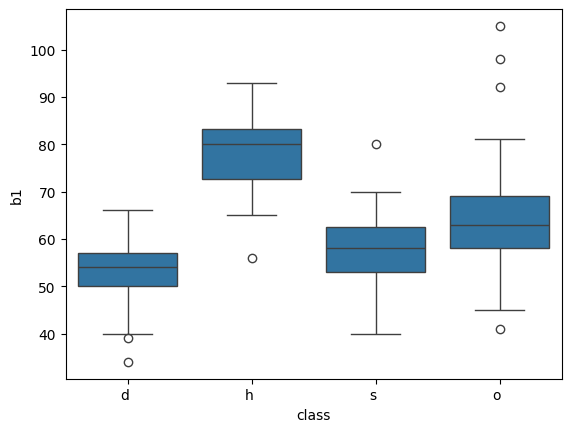

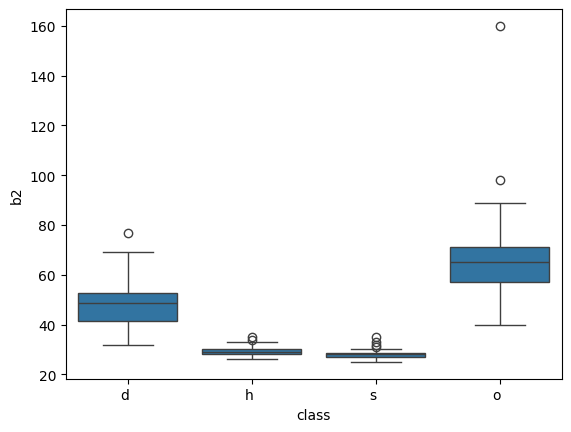

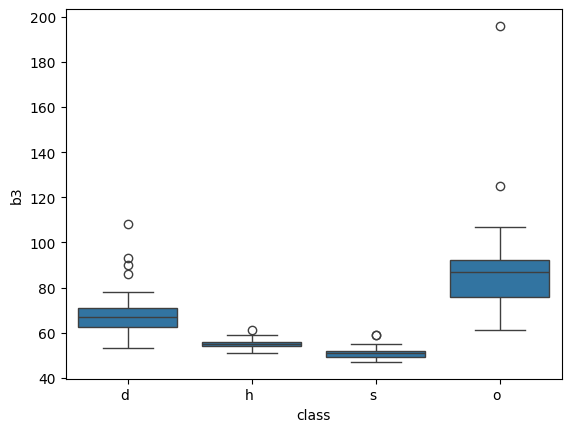

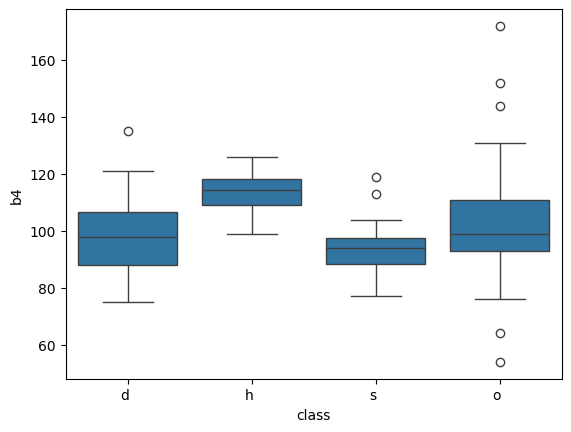

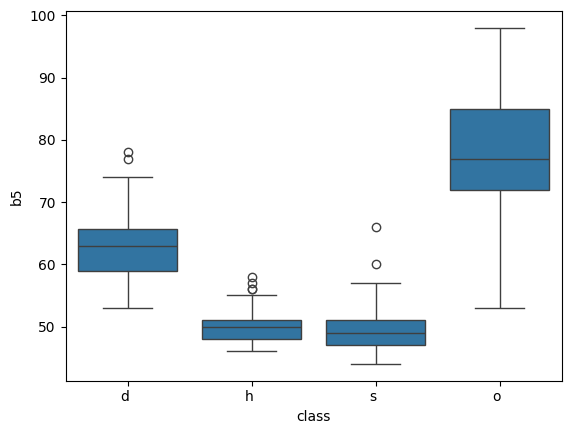

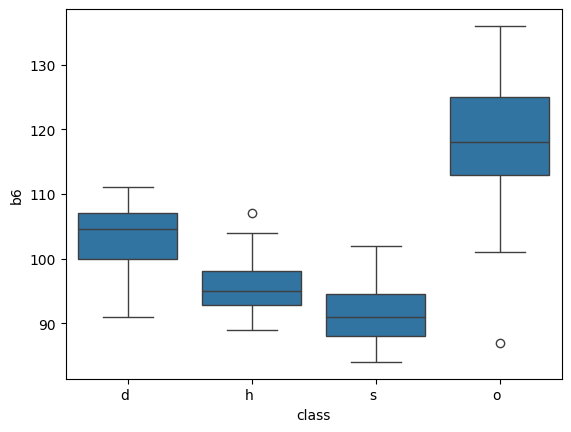

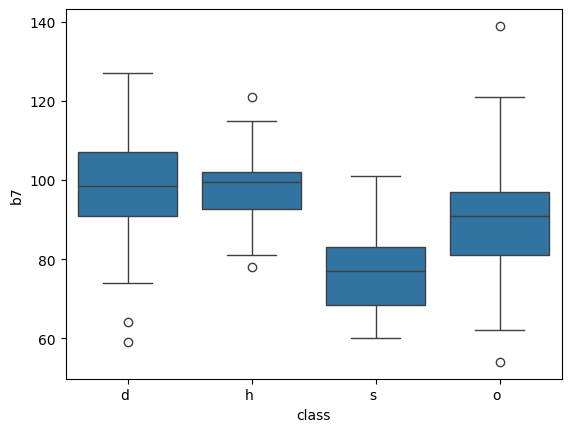

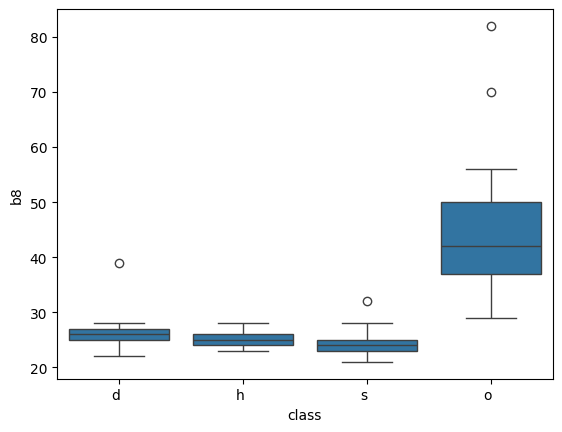

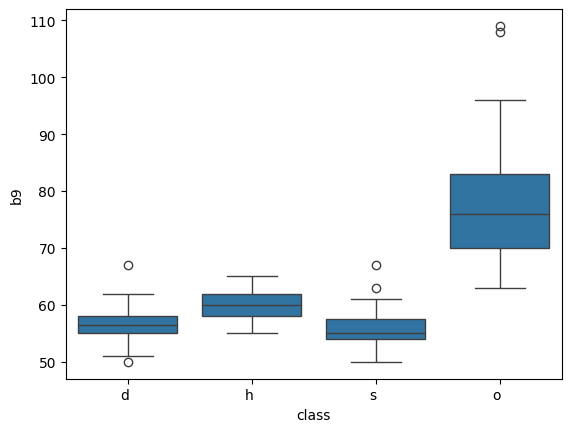

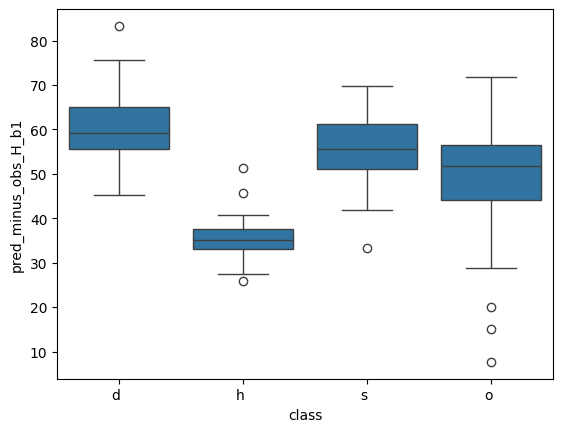

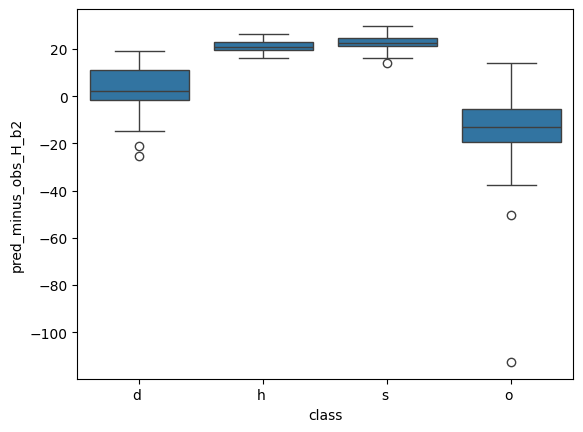

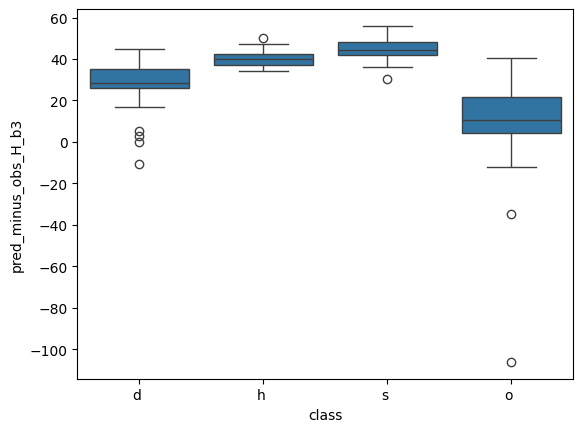

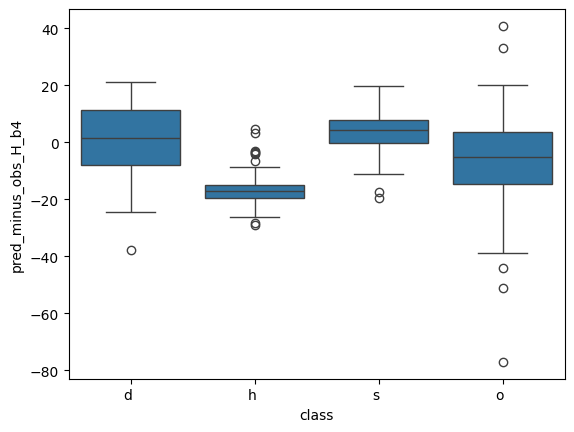

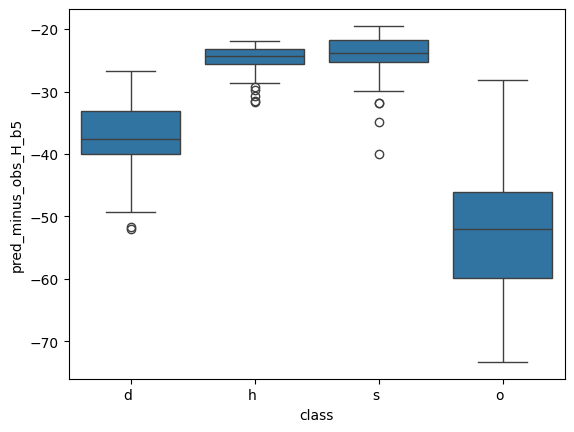

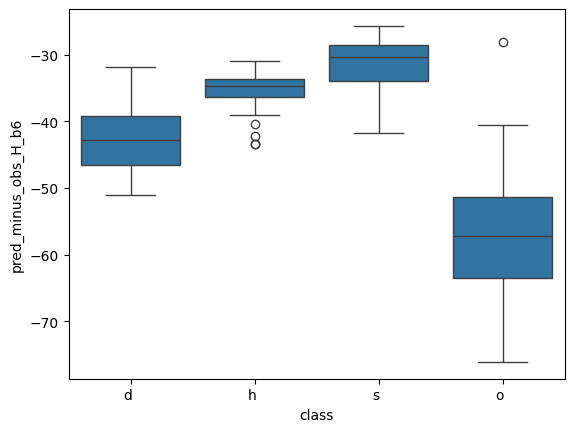

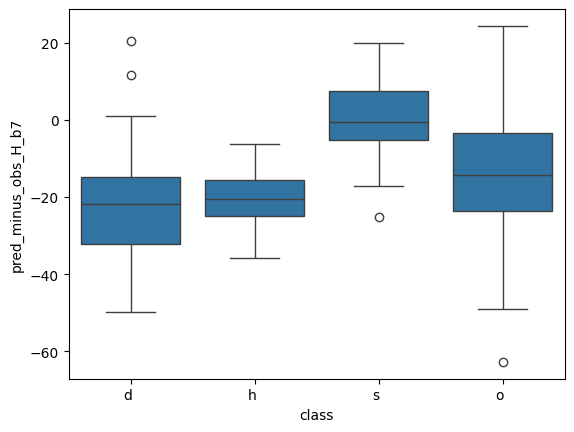

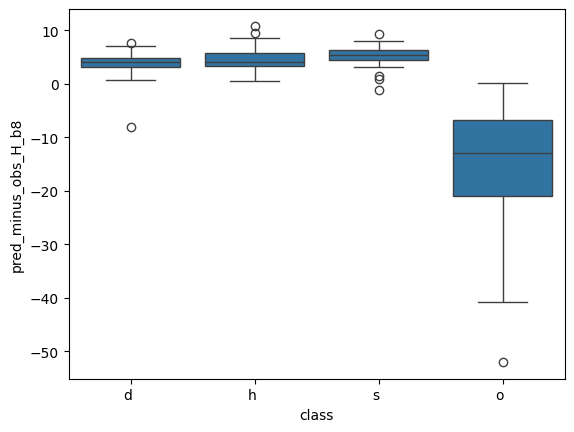

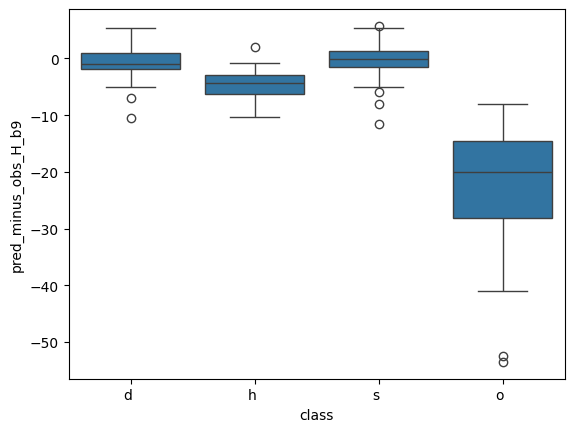

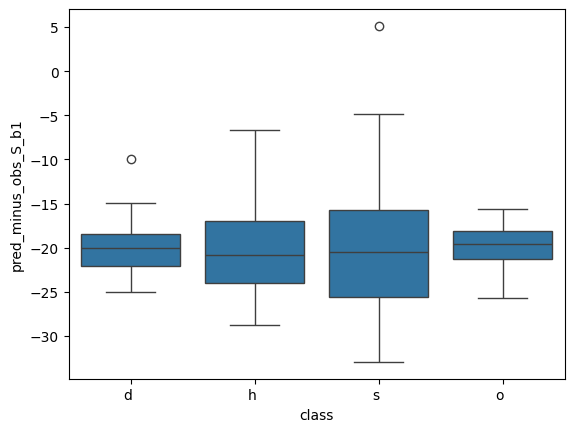

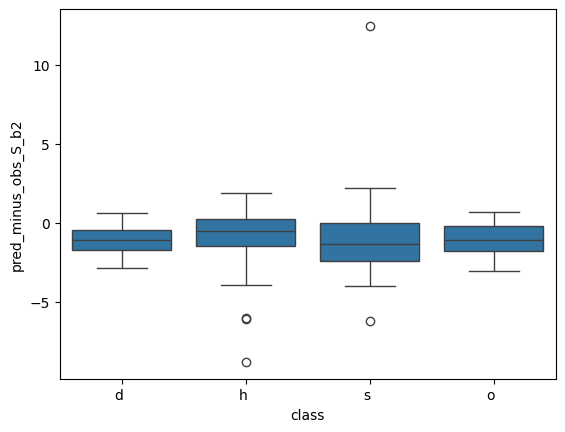

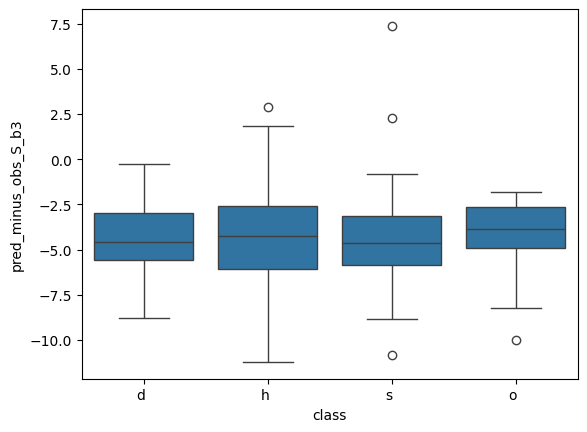

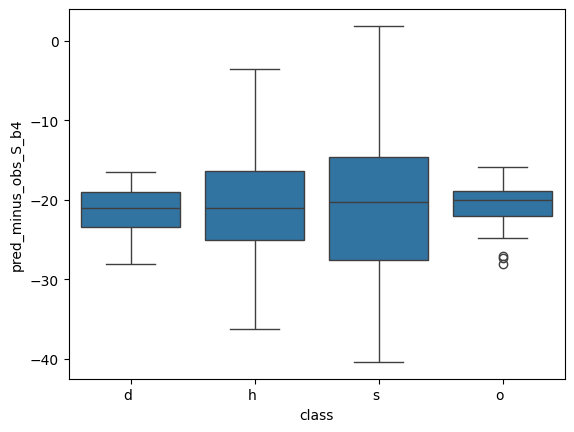

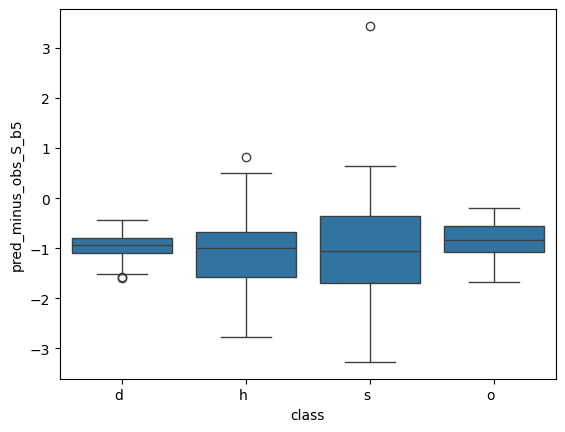

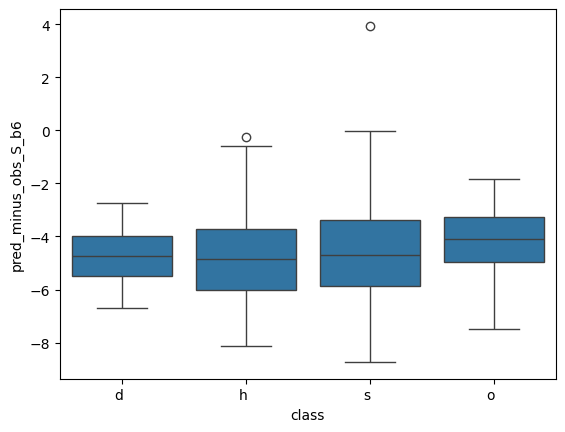

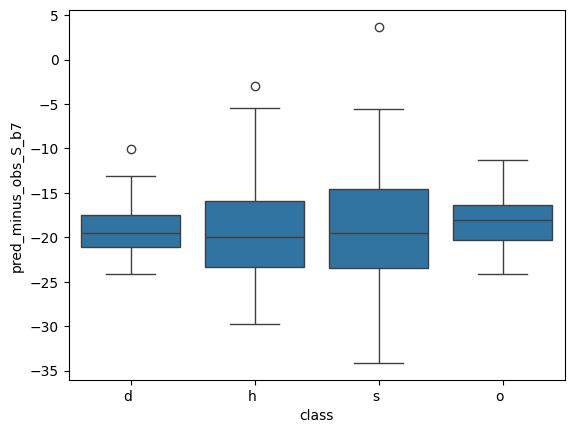

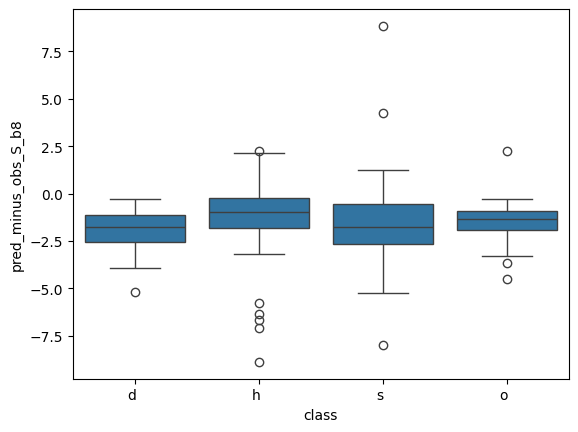

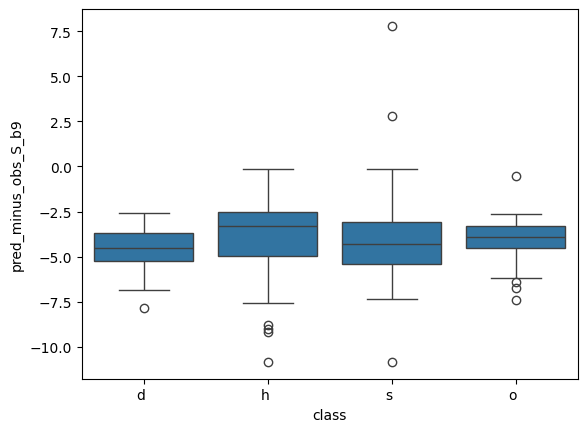

In [83]:
for variable in X_q2_train.columns:
    sns.boxplot(x = 'class', y = variable, data = q2_train)
    plt.show()

All variables appear to have different distributions. Therefore, to improve performance, it might be wise to standardise the data 

In [94]:
mu = np.mean(X_q2_train, 0)
sigma = np.std(X_q2_train, 0)

X_standardised_train = (X_q2_train - mu) / sigma
X_standardised_test = (X_q2_test - mu) / sigma
X_standardised_val = (X_q2_val - mu) / sigma

## Training a K-Nearest Neighbours Classifier

No Standardisation

In [119]:
cknn_model = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
cknn_model.fit(X_q2_train, y_q2_train)

KNeighborsClassifier(n_neighbors=10)

(<Figure size 2000x1000 with 6 Axes>,
 <Axes: title={'center': 'Validation Set'}, xlabel='Predicted label', ylabel='True label'>)

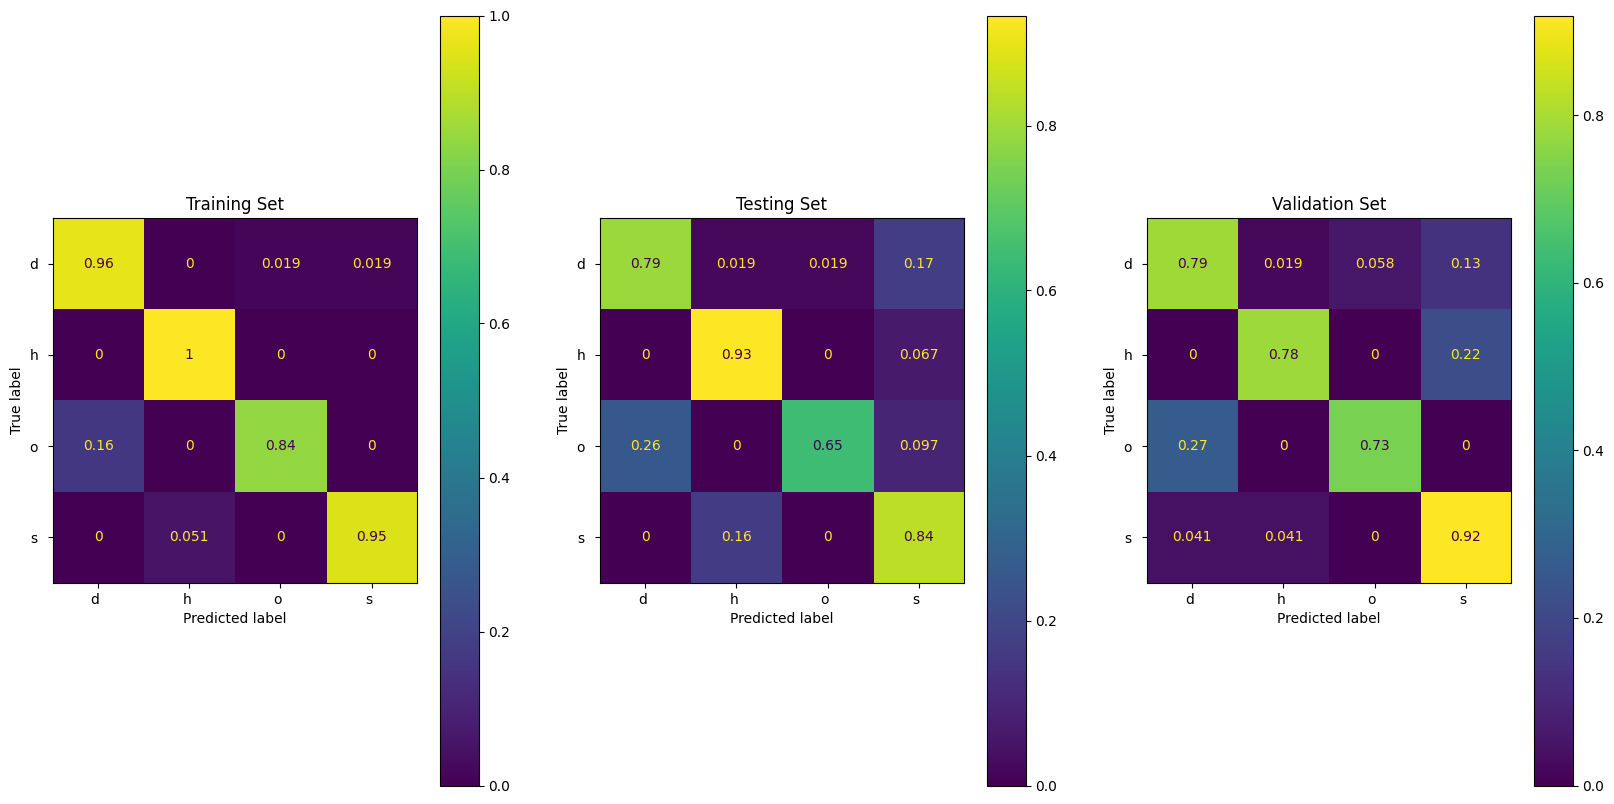

In [120]:
generate_figures(cknn_model, 3, [X_q2_train, X_q2_test, X_q2_val], [y_q2_train, y_q2_test, y_q2_val], ['Training Set', 'Testing Set', 'Validation Set'])

              precision    recall  f1-score   support

          d        0.84      0.79      0.82        53
          h        0.56      0.93      0.70        15
          o        0.95      0.65      0.77        31
          s        0.80      0.84      0.82        62

    accuracy                           0.80       161
   macro avg       0.79      0.80      0.78       161
weighted avg       0.82      0.80      0.80       161



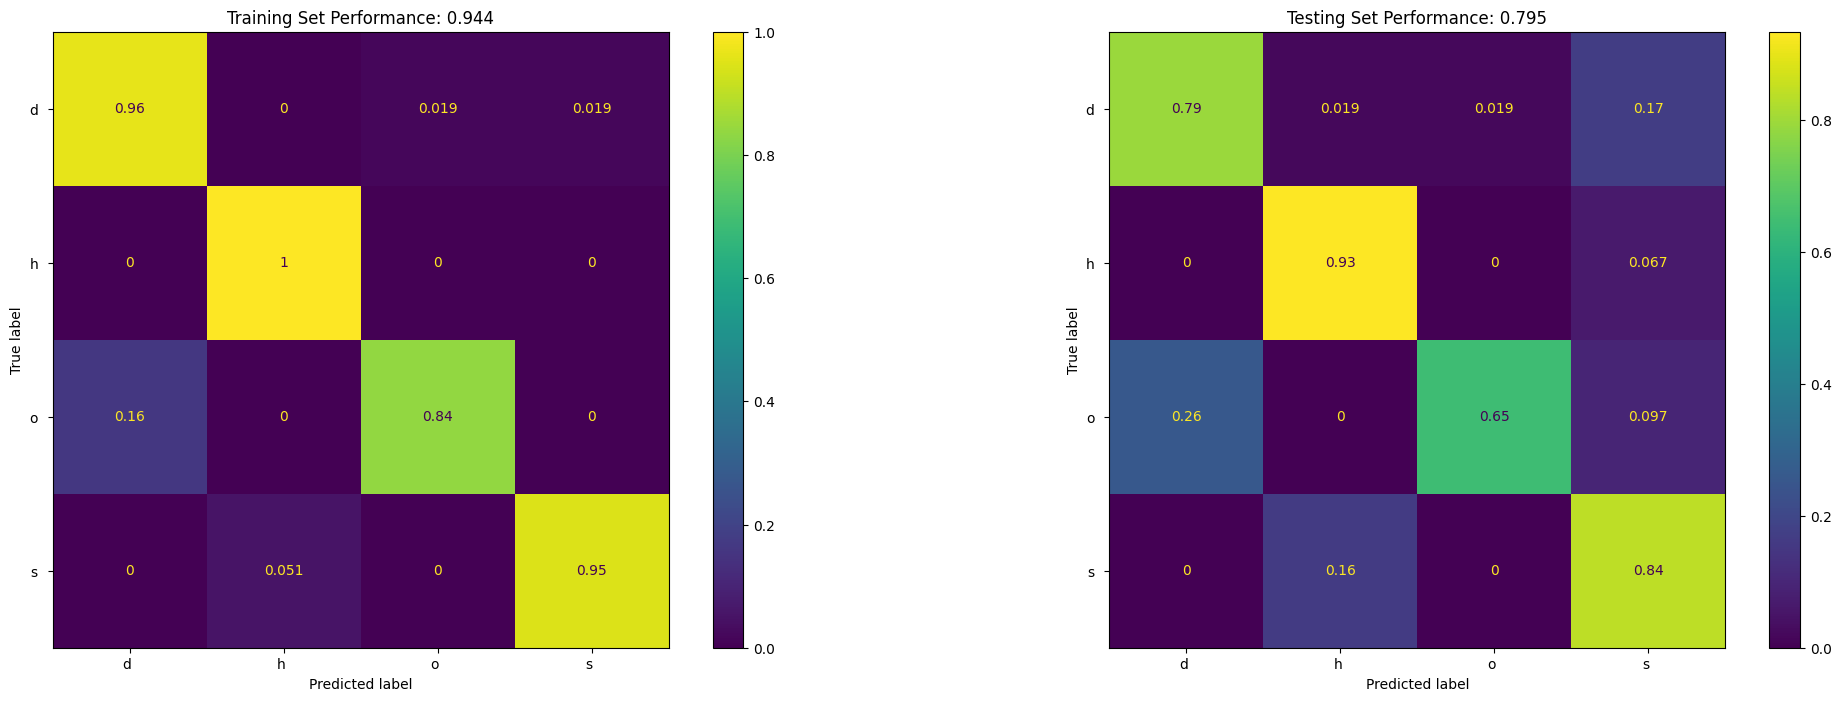

In [121]:
eval_model(cknn_model, X_q2_train, y_q2_train, X_q2_test, y_q2_test)

Using GridSearchCV to optimise hyperparameters

{'n_neighbors': 3, 'weights': 'uniform'}
              precision    recall  f1-score   support

          d        0.82      0.85      0.83        53
          h        0.60      0.80      0.69        15
          o        0.96      0.74      0.84        31
          s        0.82      0.82      0.82        62

    accuracy                           0.81       161
   macro avg       0.80      0.80      0.79       161
weighted avg       0.83      0.81      0.82       161



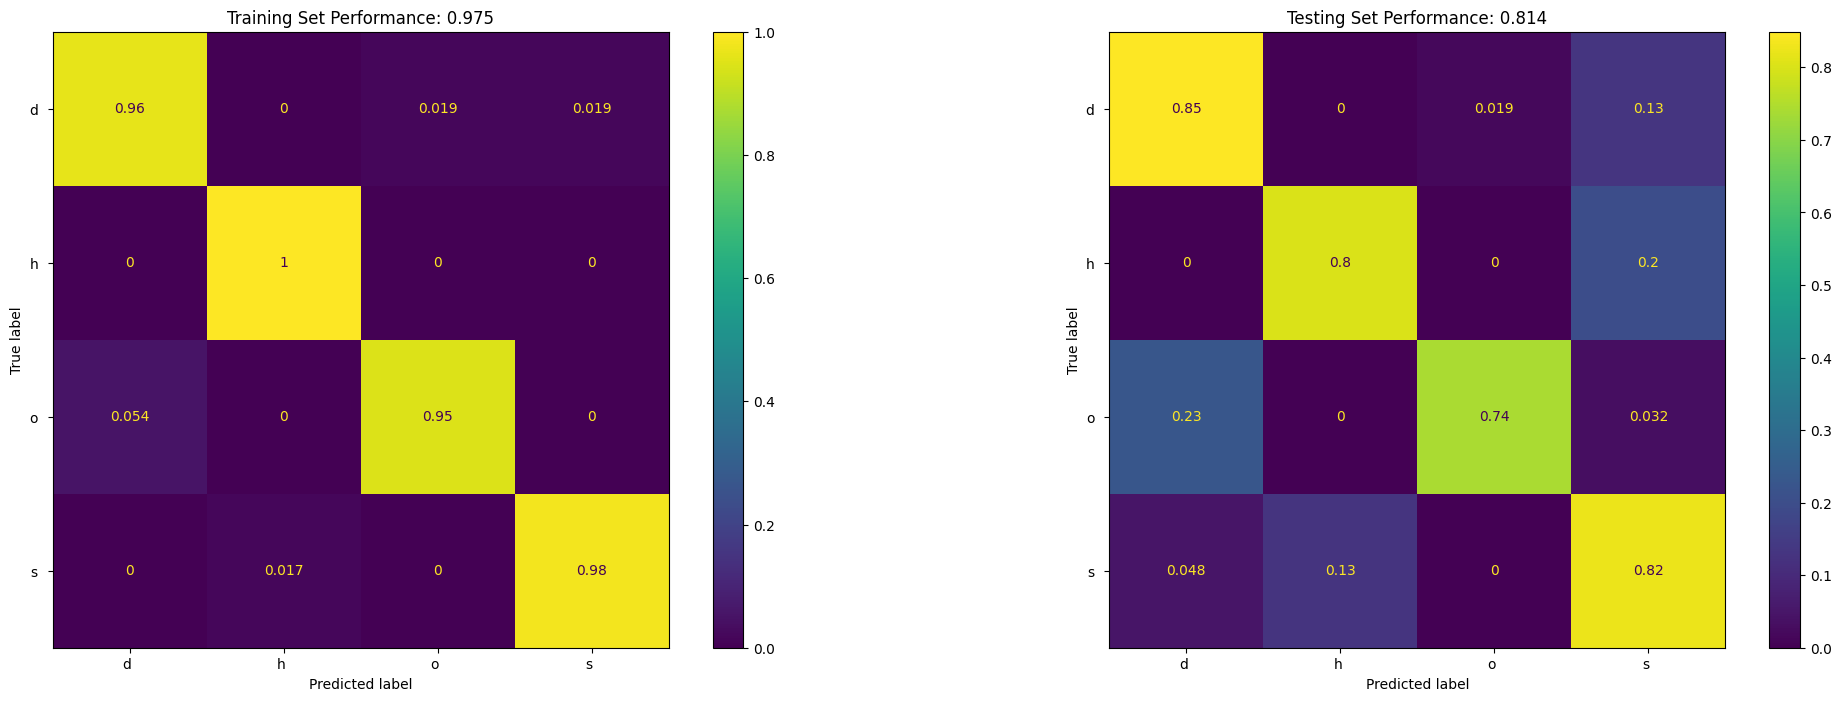

In [ ]:
parameters_grid_cknn = [
    {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
]

cknn_best_neighbours = KNeighborsClassifier()
grid_search = GridSearchCV(cknn_best_neighbours, parameters_grid_cknn, cv = 5)
grid_search.fit(X_q2_val, y_q2_val)

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)

cknn_best_parameters_model = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights = params['weights'])
cknn_best_parameters_model.fit(X_standardised_train, y_q2_train)

eval_model(cknn_best_parameters_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

In [128]:
distance_measures = []  

for i in distance_metrics().keys():
    distance_measures.append(i)
    

Using Standardisation

In [ ]:
cknn_model_standardised = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
cknn_model_standardised.fit(X_standardised_train, y_q2_train)

KNeighborsClassifier(n_neighbors=10)

(<Figure size 2000x1000 with 6 Axes>,
 <Axes: title={'center': 'Validation Data'}, xlabel='Predicted label', ylabel='True label'>)

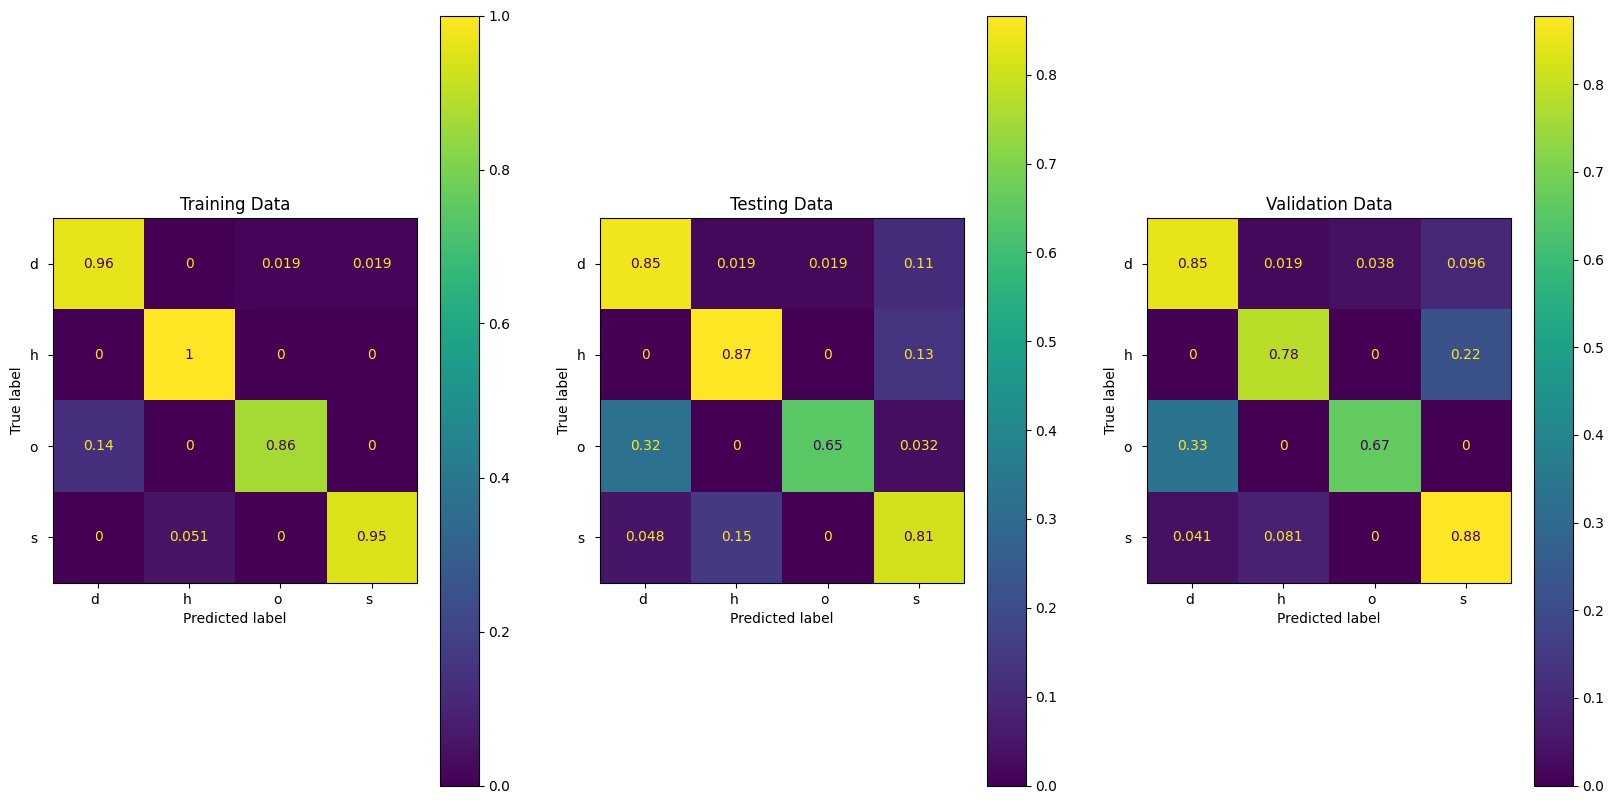

In [ ]:
generate_figures(cknn_model_standardised, 3, [X_standardised_train, X_standardised_test, X_standardised_val], [y_q2_train, y_q2_test, y_q2_val], ['Training Data', 'Testing Data', 'Validation Data'])

There appears to be a little overfitting on the training set, with performance suffering slightly on the 'o' class. Time to use GridSearchCV to optimise the hyperparameters

In [130]:
distance_measures

['cityblock',
 'cosine',
 'euclidean',
 'haversine',
 'l2',
 'l1',
 'manhattan',
 'precomputed',
 'nan_euclidean']

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

          d        0.82      0.85      0.83        53
          h        0.63      0.80      0.71        15
          o        0.96      0.74      0.84        31
          s        0.81      0.82      0.82        62

    accuracy                           0.81       161
   macro avg       0.80      0.80      0.80       161
weighted avg       0.82      0.81      0.82       161



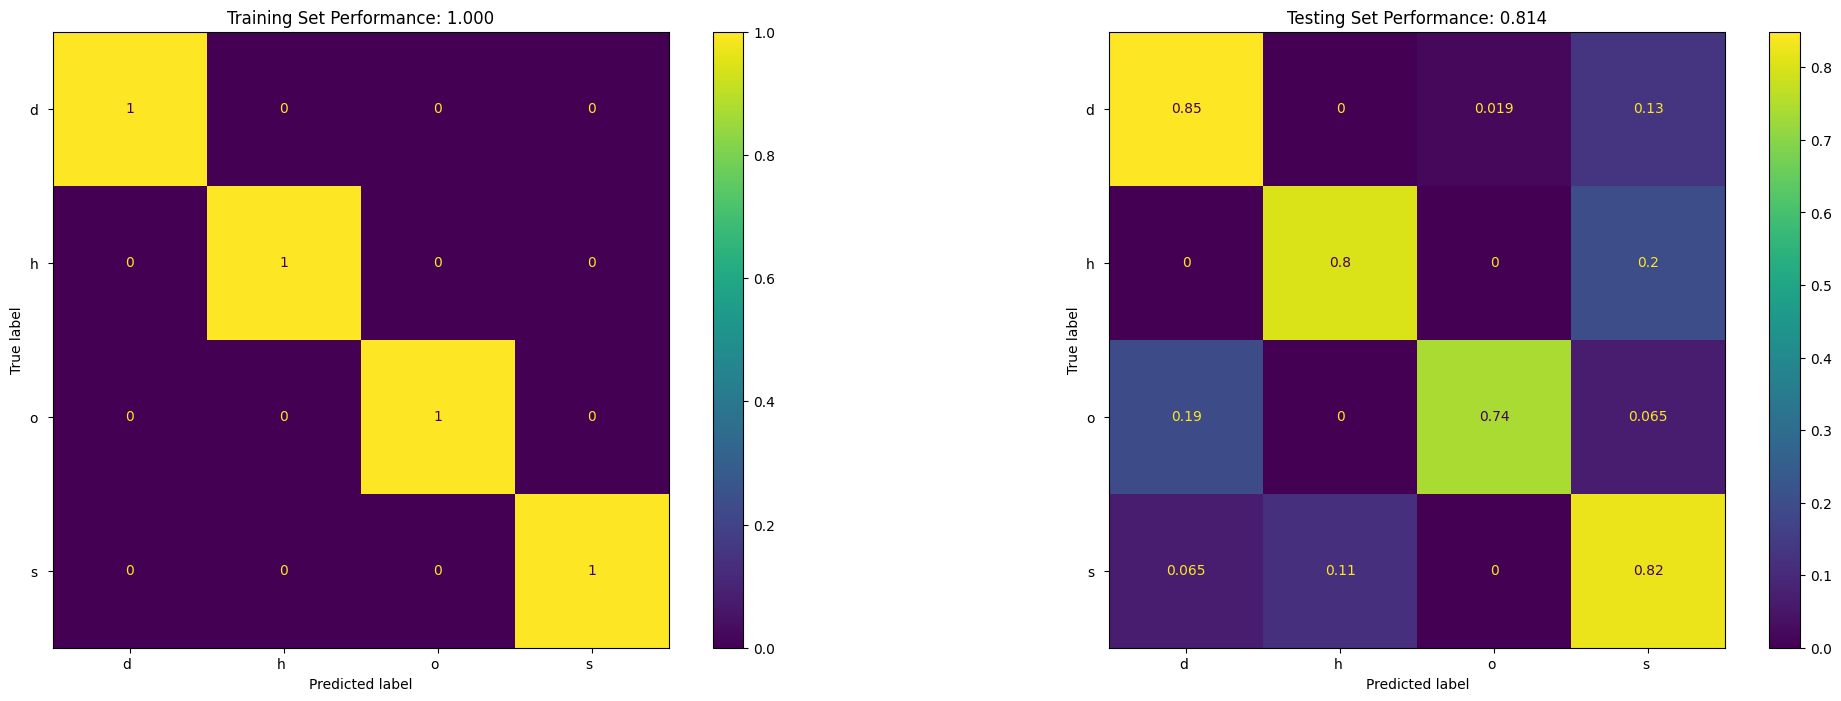

In [133]:
parameters_grid_cknn = [
    {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    }
]

cknn_best_neighbours = KNeighborsClassifier()
grid_search = GridSearchCV(cknn_best_neighbours, parameters_grid_cknn, cv = 5)
grid_search.fit(X_standardised_val, y_q2_val)

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)

cknn_best_parameters_model = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights = params['weights'])
cknn_best_parameters_model.fit(X_standardised_train, y_q2_train)

eval_model(cknn_best_parameters_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

Comparing against the old model (standardised)

              precision    recall  f1-score   support

          d        0.78      0.85      0.81        53
          h        0.57      0.87      0.68        15
          o        0.95      0.65      0.77        31
          s        0.85      0.81      0.83        62

    accuracy                           0.80       161
   macro avg       0.79      0.79      0.77       161
weighted avg       0.82      0.80      0.80       161



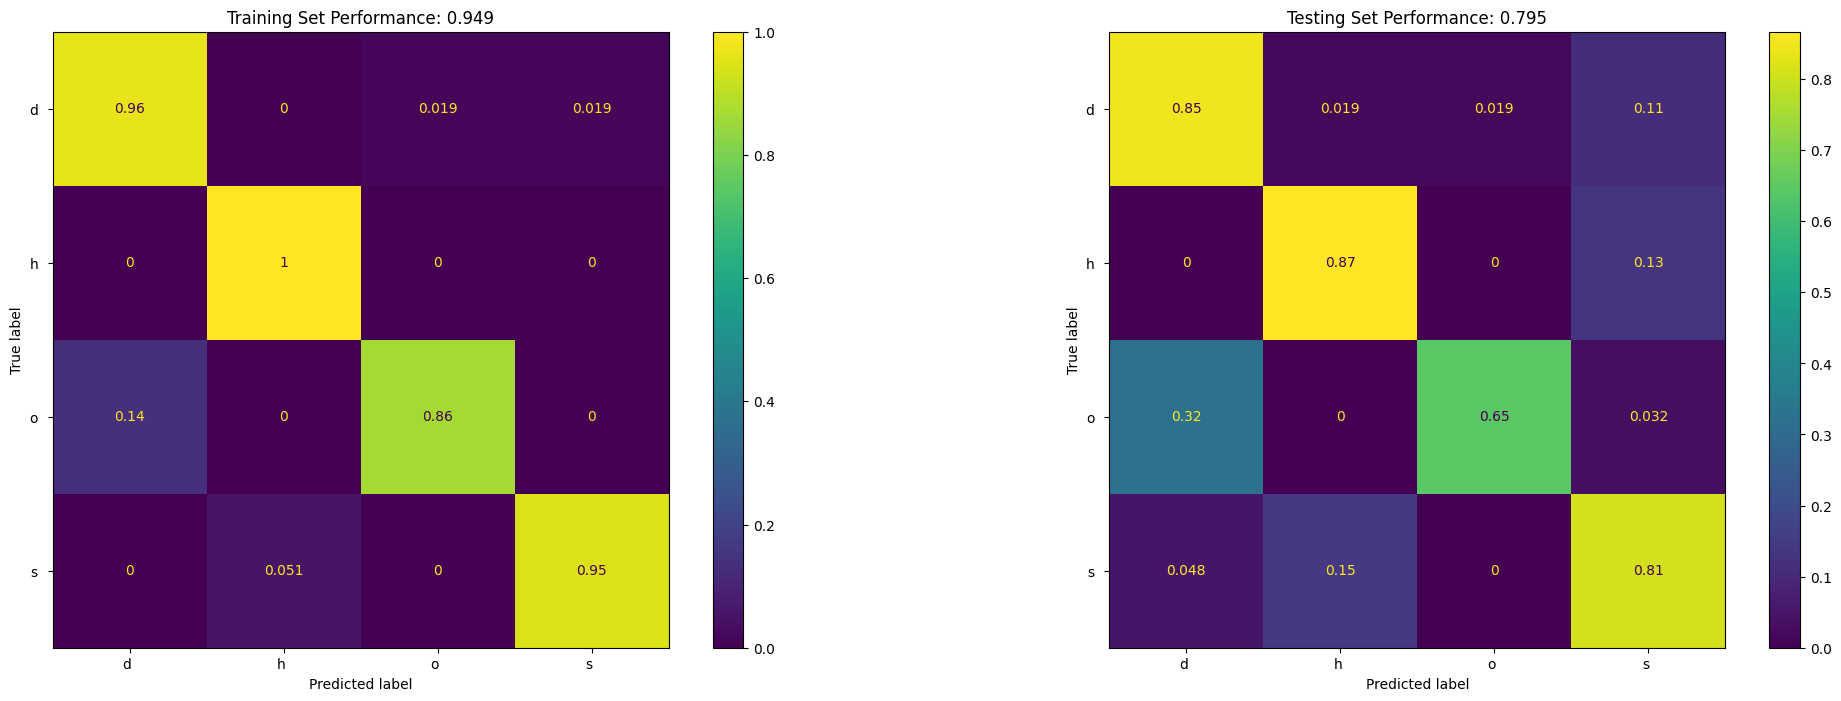

In [114]:
eval_model(cknn_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

## Training a Random Forest

(<Figure size 2000x1000 with 6 Axes>,
 <Axes: title={'center': 'Validation Data'}, xlabel='Predicted label', ylabel='True label'>)

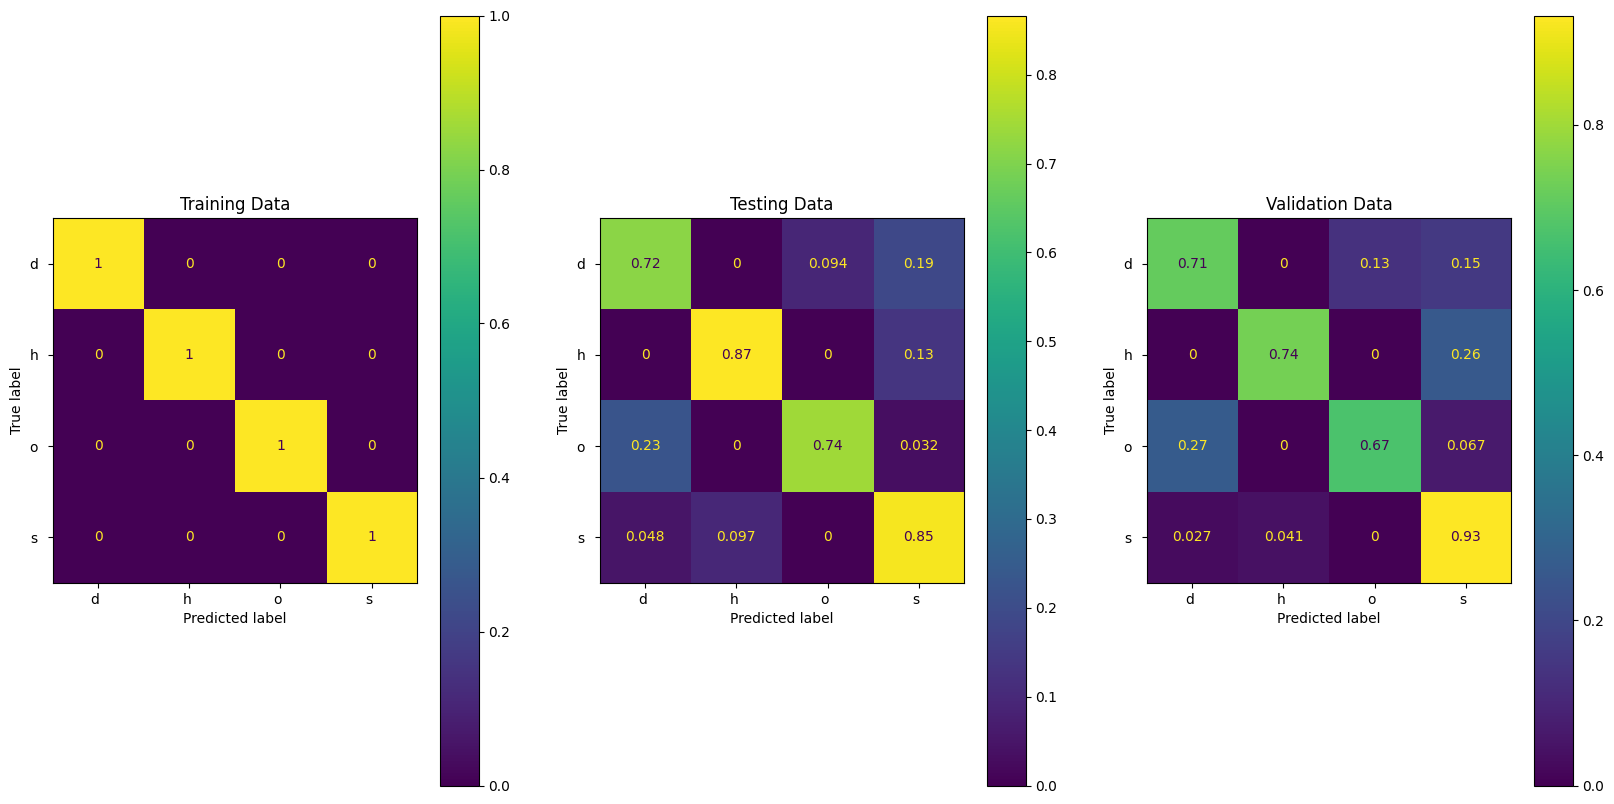

In [98]:
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
rf_model.fit(X_standardised_train, y_q2_train)

generate_figures(rf_model, 3, [X_standardised_train, X_standardised_test, X_standardised_val], [y_q2_train, y_q2_test, y_q2_val], ['Training Data', 'Testing Data', 'Validation Data'])

The original random forest model does not work well on the validation set. Time to look at the GridSearchCV to optimise the hyperparameters

{'max_depth': 20, 'n_estimators': 150}
              precision    recall  f1-score   support

          d        0.79      0.70      0.74        53
          h        0.68      0.87      0.76        15
          o        0.80      0.77      0.79        31
          s        0.82      0.85      0.83        62

    accuracy                           0.79       161
   macro avg       0.77      0.80      0.78       161
weighted avg       0.79      0.79      0.79       161



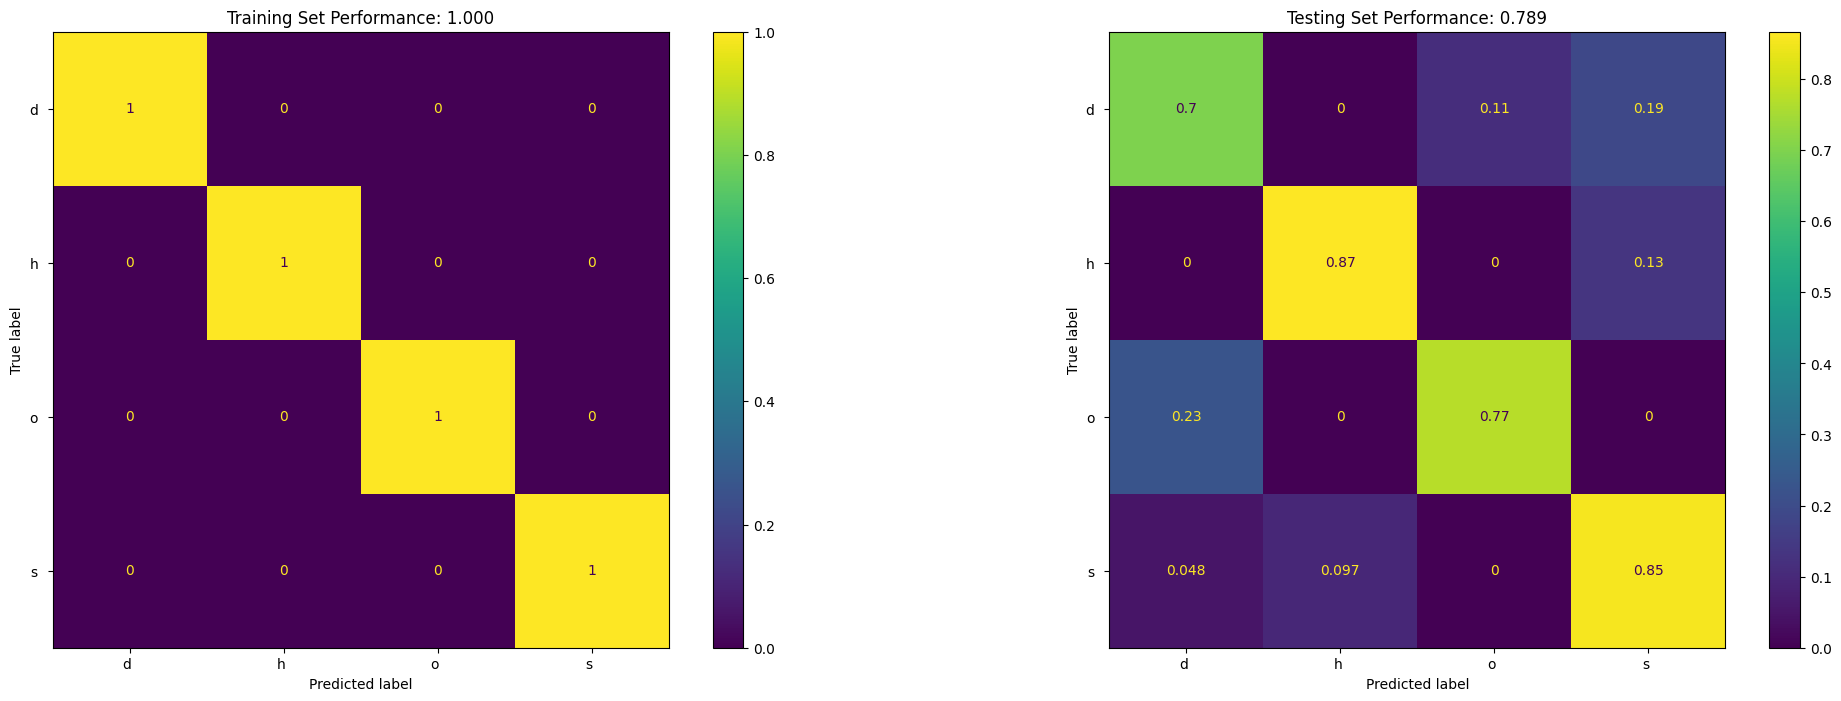

In [116]:
parameters_grid_rf = [
    {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [5, 10, 15, 20]
    }
]

rf_best_estimators = RandomForestClassifier()
grid_search = GridSearchCV(rf_best_estimators, parameters_grid_rf, cv = 5)
grid_search.fit(X_standardised_val, y_q2_val)

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)

rf_best_parameters_model = RandomForestClassifier(n_estimators = params['n_estimators'], max_depth = params['max_depth'])
rf_best_parameters_model.fit(X_standardised_train, y_q2_train)

eval_model(rf_best_parameters_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

It appears that the lowest performance is improved (on the 'o' class)

## Training an SVM

In [ ]:
svm_model = SVC(C = 1, kernel = 'linear', random_state = 42)
svm_model.fit(X_standardised_train, y_q2_train)


SVC(C=1, kernel='linear', random_state=42)

(<Figure size 2000x1000 with 6 Axes>,
 <Axes: title={'center': 'Validation Data'}, xlabel='Predicted label', ylabel='True label'>)

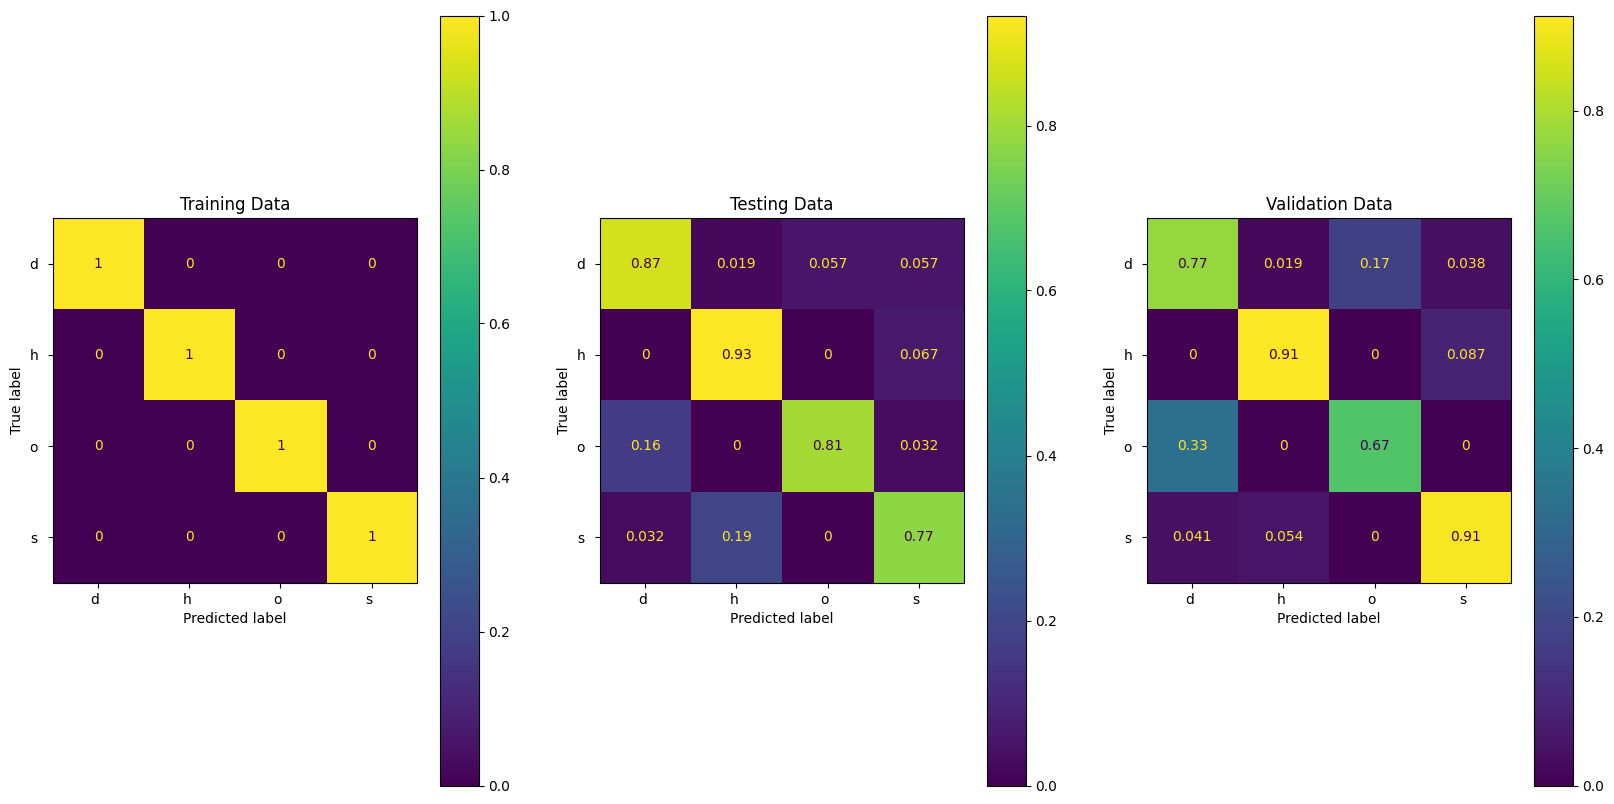

In [97]:
generate_figures(svm_model, 3, [X_standardised_train, X_standardised_test, X_standardised_val], [y_q2_train, y_q2_test, y_q2_val], ['Training Data', 'Testing Data', 'Validation Data'])

Time to use GridSearchCV to optimise hyperparameters

{'C': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

          d        0.84      0.81      0.83        53
          h        0.59      0.87      0.70        15
          o        0.89      0.81      0.85        31
          s        0.87      0.84      0.85        62

    accuracy                           0.83       161
   macro avg       0.80      0.83      0.81       161
weighted avg       0.84      0.83      0.83       161



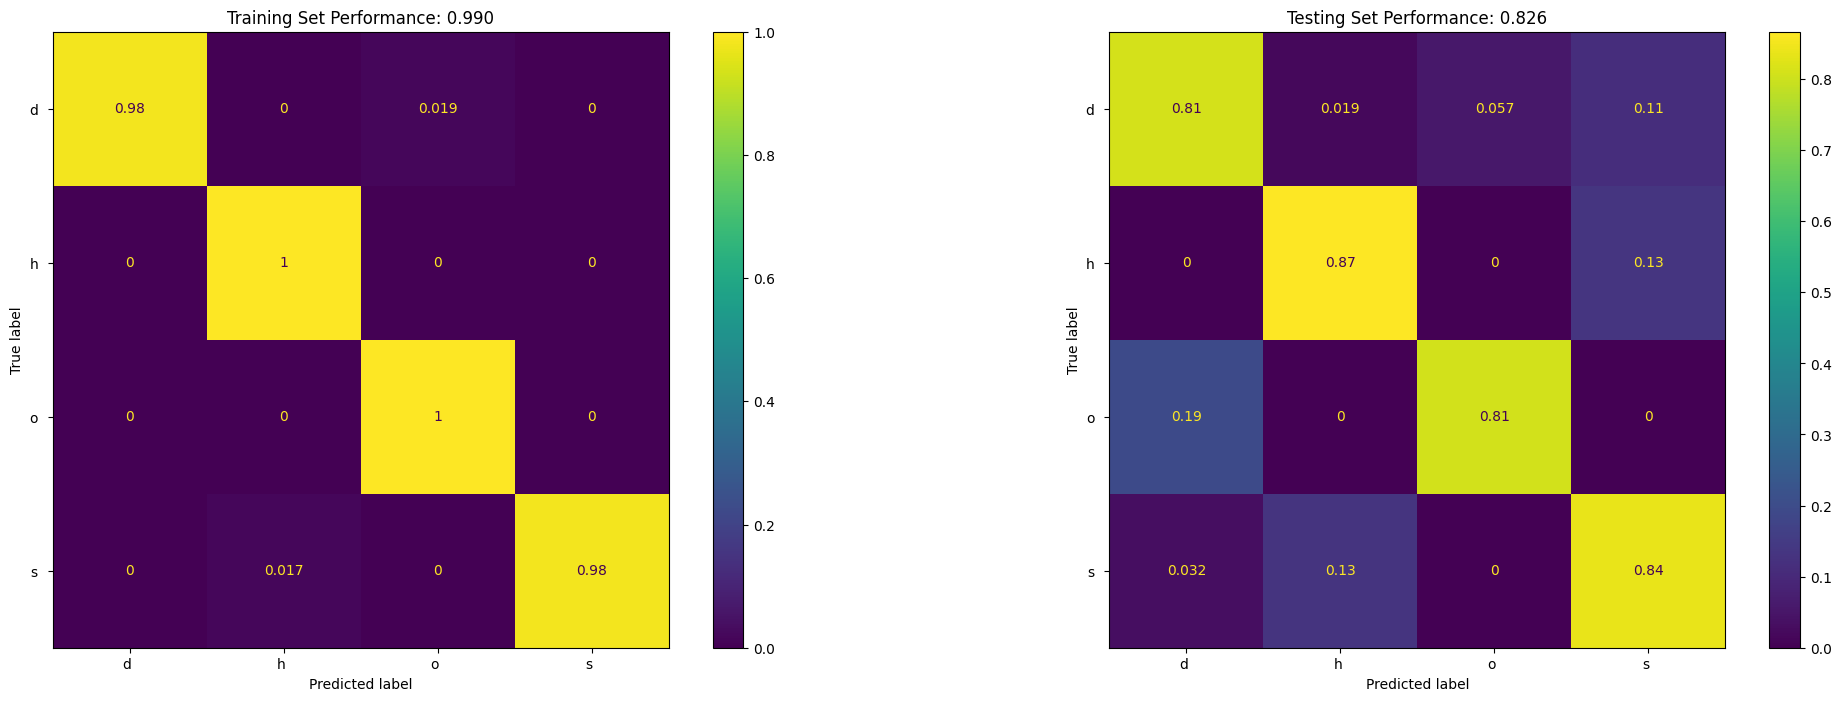

In [135]:
parameters_grid_svm = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
]

svm_best_estimators = SVC()
grid_search = GridSearchCV(svm_best_estimators, parameters_grid_svm, cv = 5)
grid_search.fit(X_standardised_val, y_q2_val)

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)

svm_best_parameters_model = SVC(C = params['C'], kernel = params['kernel'])
svm_best_parameters_model.fit(X_standardised_train, y_q2_train)

eval_model(svm_best_parameters_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

The best parameters model appears to have solid performance on the testing set. Checking the original model

In [ ]:
eval_model(svm_model, X_standardised_train, y_q2_train, X_standardised_test, y_q2_test)

## Question 3 - Training and Adapting Deep Networks

When training deep neural networks, the availability of data is a frequent challenge. As such, methods including fine tuning and data augmentation are common practices to address data challenges.

You have been provided with three portions of data from the Street View House Numbers (SVHN) dataset, a ‘real world’ MNIST style dataset. The three data portions are:

A training set, Q3/q3 train.mat, containing 1, 000 samples distributed across the 10 classes.
A validation set, Q3/q3 validation.mat, containing 1, 000 samples distributed across the 10 classes.
A testing set, Q3/q3 test.mat, 10, 000 samples distributed across the 10 classes.
Data sets do no overlap, and have been extracted randomly from the original SVHN test set. Note that the training set being significantly smaller than the test set is by design, and is not an error. The provided template code implements an SVM to classify this data, and
provides code to time how long the SVM takes during training and testing

Using this data
Using these datasets and the provided code, you are to:

Design/select a DCNN architecture, and using this network:
Train a model from scratch, using no data augmentation, on the provided abridged SVHN training set.
Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.
Compare the performance of two DCNNs (with and without augmentation), considering the accuracy, training time and inference time (i.e. time taken to evaluate the
models), using the provided test set.
All models should be evaluated on the provided SVHN test set, and their performance should be compared. DCNN architectures may be taken from lecture examples or practical solutions. Your selection of model may take computational constraints into consideration.